In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
!pip install torch_summary

In [2]:
data_dir = 'C:\\Users\\k.stavrianos\\PycharmProjects\\BrainTumorDetection\\dataset\\content\\'

In [3]:
class tutor_dataset(Dataset):
    def __init__(self, folder):
        positive = glob(folder + '\\yes\\*')
        negative = glob(folder + '\\no\\*')
        self.fpaths = positive + negative
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('\\')[-1].startswith('Y') for fpath in self.fpaths]
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)    

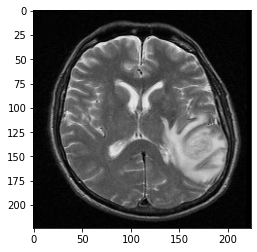

In [29]:
data = tutor_dataset(data_dir)
im, label = data[50]
for i in range(250):
    im, label = data[i]
    plt.imshow(im.permute(1,2,0).cpu())

In [5]:
len(data)

253

tensor([1.])


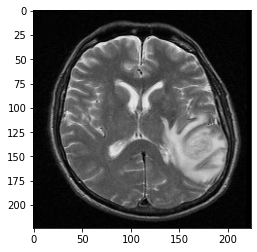

In [6]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [7]:
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential(
    nn.Conv2d(ni, no, kernel_size, stride),
    nn.ReLU(),
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2)
    )
def get_model():
    model = nn.Sequential(
    conv_layer(3, 64, 3),
    conv_layer(64, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    nn.Flatten(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)
    return model, loss_fn, optimizer

In [8]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  128
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       295,424
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  1,024
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       2,359,808
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 1,024
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      2,359,808
|    └─ReLU: 2-14                        --
|    └─BatchNorm2d: 2-15                 1,024
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-5                      

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  128
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       295,424
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  1,024
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       2,359,808
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 1,024
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      2,359,808
|    └─ReLU: 2-14                        --
|    └─BatchNorm2d: 2-15                 1,024
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-5                      

In [9]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [10]:
def get_data(data_dir):     
    dataset = tutor_dataset(data_dir)
    validation_split = 0.2
    shuffle_dataset = True
    random_seed = 42
    
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    
    
    trn_dl = DataLoader(dataset, batch_size=32, drop_last = True, sampler = train_sampler)
    val_dl = DataLoader(dataset, batch_size=32, drop_last = True, sampler = valid_sampler)
    
    return trn_dl, val_dl

In [11]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [12]:
trn_dl, val_dl = get_data(data_dir)
model, loss_fn, optimizer = get_model()

In [14]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(20):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        print("enumeration: " + str(ix))
        x, y = batch
        batch_loss = train_batch(x,y,model,optimizer,loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
enumeration: 0
enumeration: 1
enumeration: 2
enumeration: 3
enumeration: 4
enumeration: 5
1
enumeration: 0
enumeration: 1
enumeration: 2
enumeration: 3
enumeration: 4
enumeration: 5
2
enumeration: 0
enumeration: 1
enumeration: 2
enumeration: 3
enumeration: 4
enumeration: 5
3
enumeration: 0
enumeration: 1
enumeration: 2
enumeration: 3
enumeration: 4
enumeration: 5
4
enumeration: 0
enumeration: 1
enumeration: 2
enumeration: 3
enumeration: 4
enumeration: 5
5
enumeration: 0
enumeration: 1
enumeration: 2
enumeration: 3
enumeration: 4
enumeration: 5
6
enumeration: 0
enumeration: 1
enumeration: 2
enumeration: 3
enumeration: 4
enumeration: 5
7
enumeration: 0
enumeration: 1
enumeration: 2
enumeration: 3
enumeration: 4
enumeration: 5
8
enumeration: 0
enumeration: 1
enumeration: 2
enumeration: 3
enumeration: 4
enumeration: 5
9
enumeration: 0
enumeration: 1
enumeration: 2
enumeration: 3
enumeration: 4
enumeration: 5
10
enumeration: 0
enumeration: 1
enumeration: 2
enumeration: 3
enumeration: 4
en

In [15]:
len(train_epoch_accuracies)

192

In [16]:
len(train_epoch_accuracies[0])

1

<ipython-input-17-3b68e98f7855>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


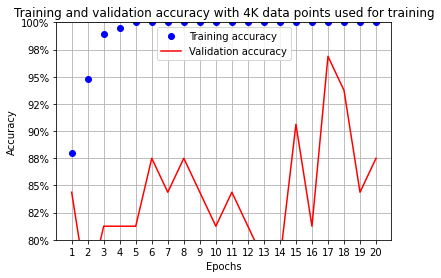

In [17]:
epochs = np.arange(20)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()


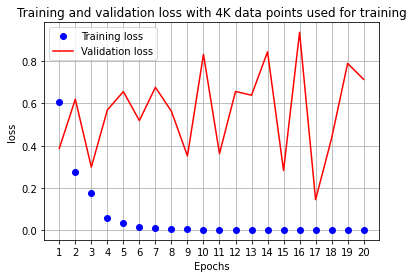

In [30]:
epochs = np.arange(20)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.grid('off')
plt.show()


In [20]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        

In [23]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/tutor_experiment_1')

In [24]:
dataiter = iter(trn_dl)
images, labels = dataiter.next()

In [25]:
img_grid = torchvision.utils.make_grid(images)

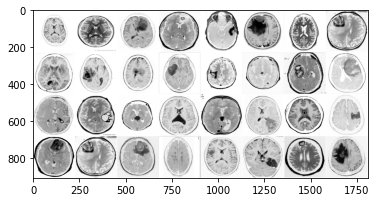

In [26]:
matplotlib_imshow(img_grid, one_channel=True)

In [27]:
writer.add_image('tumor_images', img_grid)

In [28]:
writer.add_graph(model, images)
writer.close()